# COQ4
Variants in COQ4 are associated with 
[Coenzyme Q10 deficiency, primary, 7; OMIM616276](https://omim.org/entry/616276) and 
[Spastic ataxia 10, autosomal recessive; OMIM:620666](https://omim.org/entry/620666).

Pathogenic COQ4 variants in exons 1-4 are associated with less life-threating presentations, late onset, responsiveness to CoQ10 therapy, and a relatively long lifespan ([Xie et al. (2021)](https://pubmed.ncbi.nlm.nih.gov/35154243/)). Correction for multiple testing was not performed.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.9.1


# COQ4
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for COQ4.

In [2]:
gene_symbol = 'COQ4'
mane_tx_id = 'NM_016035.5'
mane_protein_id = 'NP_057119.3' # ubiquinone biosynthesis protein COQ4 homolog, mitochondrial isoform 1 precursor [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.23') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 51/51 [00:00<00:00, 1220.21individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
23,Increased serum lactate
17,Hypotonia
14,Lower limb hyperreflexia
14,Global developmental delay
13,Seizure
12,Lower limb spasticity
12,Babinski sign
11,Respiratory insufficiency
11,Cerebellar hypoplasia
10,Cerebellar atrophy


# Domains
Note that according to UniProt Q9Y3A0 (Ubiquinone biosynthesis protein COQ4 homolog, mitochondrial) there are no protein domains to display so we show only the location of the variants. For this reason we create an empty dataframe

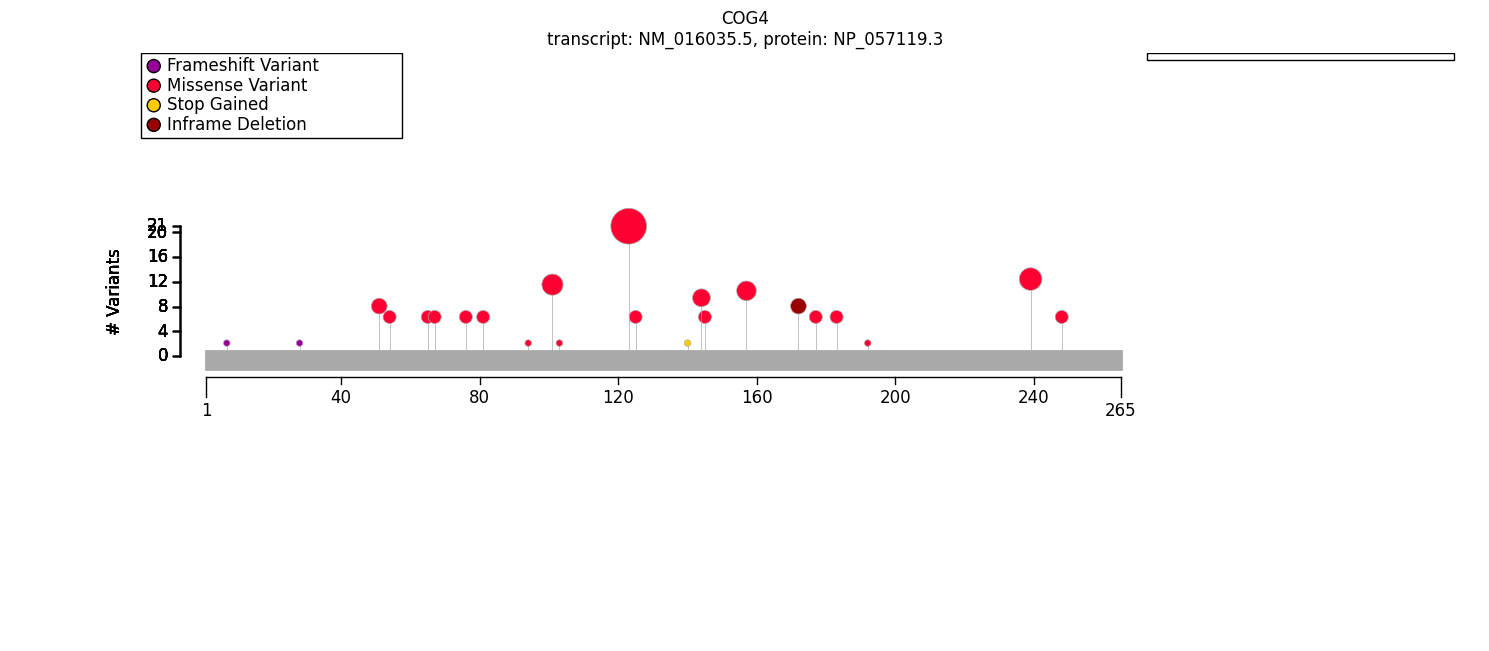

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
import pandas as pd
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
features = []
df = pd.DataFrame(features, columns=["region","category","start", "end"])
protein_meta = ProteinMetadata.from_feature_frame(protein_id=mane_protein_id, label="COG4", features=df, protein_length=265)


COG4_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
COG4_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import  biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_clf = biallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense", 
    b_label="other",
    partitions=((1,0),(2,))
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,24
HMF05,Skipping term because one genotype had zero observations,9
HMF08,Skipping general term,69
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,175


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/other OR missense/missense  \
                                                                                 Count   
Cerebellar atrophy [HP:0001272]                                                   8/26   
Lower limb spasticity [HP:0002061]                                               14/22   
Morphological central nervous system abnormalit...                               27/27   
Abnormal brain morphology [HP:0012443]                                           26/26   

Allele group                                               other/other  \
                                                   Percent       Count   
Cerebellar atrophy [HP:0001272]                        31%         2/2   
Lower limb spasticity [HP:0002061]                     64%         0/2   
Morphological central nervous system abnormalit...    100%         2/2   
Abnormal brain morphology [HP:0012443]                100%         2/2   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cerebellar atrophy [HP:0001272]                       100%           0.326087   
Lower limb spasticity [HP:0002061]                      0%           0.326087   
Morphological central nervous system abnormalit...    100%           1.000000   
Abnormal brain morphology [HP:0012443]                100%           1.000000   

Allele group                                                  
                                                    p values  
Cerebellar atrophy [HP:0001272]                     0.119048  
Lower limb spasticity [HP:0002061]                  0.163043  
Morphological central nervous system abnormalit...  1.000000  
Abnormal brain morphology [HP:0012443]              1.000000

In [9]:
from gpsea.analysis.predicate import variant_key

is_g124s = variant_key("9_128325849_128325849_G_A") # c.370G>A	p.Gly124Ser
g124_clf = biallelic_classifier(
    a_predicate=is_g124s,
    b_predicate=~is_g124s,
    a_label="G124S",
    b_label= "other",
    partitions=((1,0),(2,))
)
g124_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf= g124_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=g124_result)

Allele group                                       G124S/other OR G124S/G124S  \
                                                                        Count   
Increased serum lactate [HP:0002151]                                    12/13   
Spasticity [HP:0001257]                                                  8/10   
Morphological central nervous system abnormalit...                        9/9   
Abnormal brain morphology [HP:0012443]                                    9/9   
Lower limb spasticity [HP:0002061]                                        4/6   
Appendicular spasticity [HP:0034353]                                      4/6   
Upper motor neuron dysfunction [HP:0002493]                               8/8   
Hypertonia [HP:0001276]                                                   8/8   
Abnormal muscle tone [HP:0003808]                                       15/15   
Hypotonia [HP:0001252]                                                   8/12   
Seizure [HP:0001250]                                                    11/13   
Acidosis [HP:0001941]                                                   12/12   

Allele group                                               other/other  \
                                                   Percent       Count   
Increased serum lactate [HP:0002151]                   92%       11/14   
Spasticity [HP:0001257]                                80%       12/17   
Morphological central nervous system abnormalit...    100%       20/20   
Abnormal brain morphology [HP:0012443]                100%       19/19   
Lower limb spasticity [HP:0002061]                     67%       10/18   
Appendicular spasticity [HP:0034353]                   67%       11/16   
Upper motor neuron dysfunction [HP:0002493]           100%       13/13   
Hypertonia [HP:0001276]                               100%       13/13   
Abnormal muscle tone [HP:0003808]                     100%       22/22   
Hypotonia [HP:0001252]                                 67%        9/13   
Seizure [HP:0001250]                                   85%       12/13   
Acidosis [HP:0001941]                                 100%       11/11   

Allele group                                                                   \
                                                   Percent Corrected p values   
Increased serum lactate [HP:0002151]                   79%                1.0   
Spasticity [HP:0001257]                                71%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Lower limb spasticity [HP:0002061]                     56%                1.0   
Appendicular spasticity [HP:0034353]                   69%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   
Hypertonia [HP:0001276]                               100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Hypotonia [HP:0001252]                                 69%                1.0   
Seizure [HP:0001250]                                   92%                1.0   
Acidosis [HP:0001941]                                 100%                1.0   

Allele group                                                  
                                                    p values  
Increased serum lactate [HP:0002151]                0.595556  
Spasticity [HP:0001257]                             0.678389  
Morphological central nervous system abnormalit...  1.000000  
Abnormal brain morphology [HP:0012443]              1.000000  
Lower limb spasticity [HP:0002061]                  1.000000  
Appendicular spasticity [HP:0034353]                1.000000  
Upper motor neuron dysfunction [HP:0002493]         1.000000  
Hypertonia [HP:0001276]                             1.000000  
Abnormal muscle tone [HP:0003808]                   1.000000  


In [10]:
# Test both variants at position 240	

r240c = variant_key("9_128333565_128333565_C_T") # c.718C>T	p.Arg240Cys
r240h= variant_key("9_128333566_128333566_G_A") # c.719G>A	p.Arg240His
r240var = r240c | r240h

r124_clf = biallelic_classifier(
    a_predicate=r240var,
    b_predicate=~r240var,
    a_label="G124S",
    b_label= "other",
    partitions=((1,0),(2,))
)
r124_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r124_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=r124_result)

Allele group                                       G124S/other OR G124S/G124S  \
                                                                        Count   
Cerebellar atrophy [HP:0001272]                                           0/4   
Increased serum lactate [HP:0002151]                                      2/3   
Hypotonia [HP:0001252]                                                    3/3   
Spasticity [HP:0001257]                                                   3/5   
Morphological central nervous system abnormalit...                        4/4   
Abnormal brain morphology [HP:0012443]                                    4/4   
Lower limb spasticity [HP:0002061]                                        3/5   
Appendicular spasticity [HP:0034353]                                      3/5   
Upper motor neuron dysfunction [HP:0002493]                               3/3   
Hypertonia [HP:0001276]                                                   3/3   
Abnormal muscle tone [HP:0003808]                                         6/6   
Seizure [HP:0001250]                                                      2/2   
Acidosis [HP:0001941]                                                     2/2   

Allele group                                               other/other  \
                                                   Percent       Count   
Cerebellar atrophy [HP:0001272]                         0%       10/24   
Increased serum lactate [HP:0002151]                   67%       21/24   
Hypotonia [HP:0001252]                                100%       14/22   
Spasticity [HP:0001257]                                60%       17/22   
Morphological central nervous system abnormalit...    100%       25/25   
Abnormal brain morphology [HP:0012443]                100%       24/24   
Lower limb spasticity [HP:0002061]                     60%       11/19   
Appendicular spasticity [HP:0034353]                   60%       12/17   
Upper motor neuron dysfunction [HP:0002493]           100%       18/18   
Hypertonia [HP:0001276]                               100%       18/18   
Abnormal muscle tone [HP:0003808]                     100%       31/31   
Seizure [HP:0001250]                                  100%       21/24   
Acidosis [HP:0001941]                                 100%       21/21   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cerebellar atrophy [HP:0001272]                        42%                1.0   
Increased serum lactate [HP:0002151]                   88%                1.0   
Hypotonia [HP:0001252]                                 64%                1.0   
Spasticity [HP:0001257]                                77%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Lower limb spasticity [HP:0002061]                     58%                1.0   
Appendicular spasticity [HP:0034353]                   71%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   
Hypertonia [HP:0001276]                               100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Seizure [HP:0001250]                                   88%                1.0   
Acidosis [HP:0001941]                                 100%                1.0   

Allele group                                                  
                                                    p values  
Cerebellar atrophy [HP:0001272]                     0.265201  
Increased serum lactate [HP:0002151]                0.394530  
Hypotonia [HP:0001252]                              0.526957  
Spasticity [HP:0001257]                             0.579896  
Morphological central nervous system abnormalit...  1.000000  
Abnormal brain m

In [11]:
from gpsea.analysis.predicate import exon, anyof

e1 = exon(exon=1, tx_id=mane_tx_id)
e2 = exon(exon=2, tx_id=mane_tx_id)
e3 = exon(exon=3, tx_id=mane_tx_id)
e4 = exon(exon=4, tx_id=mane_tx_id)

exon_1_to_4 = anyof((e1, e2, e3, e4))
exon_1_to_4_clf = biallelic_classifier(
    a_predicate=exon_1_to_4,
    b_predicate=~exon_1_to_4,
    a_label="Exon 1-4",
    b_label= "other",
    partitions=((1,0),(2,))
)
exon_1_to_4_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=exon_1_to_4_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=exon_1_to_4_result)

Allele group                                       Exon 1-4/other OR Exon 1-4/Exon 1-4  \
                                                                                 Count   
Hypotonia [HP:0001252]                                                           11/19   
Spasticity [HP:0001257]                                                          16/19   
Lower limb spasticity [HP:0002061]                                               10/14   
Appendicular spasticity [HP:0034353]                                             11/14   
Seizure [HP:0001250]                                                             20/22   
Morphological central nervous system abnormalit...                               20/20   
Abnormal brain morphology [HP:0012443]                                           19/19   
Upper motor neuron dysfunction [HP:0002493]                                      17/17   
Hypertonia [HP:0001276]                                                          17/17   
Abnormal muscle tone [HP:0003808]                                                27/27   
Increased serum lactate [HP:0002151]                                             18/21   
Acidosis [HP:0001941]                                                            18/18   

Allele group                                               other/other  \
                                                   Percent       Count   
Hypotonia [HP:0001252]                                 58%         6/6   
Spasticity [HP:0001257]                                84%         4/8   
Lower limb spasticity [HP:0002061]                     71%        4/10   
Appendicular spasticity [HP:0034353]                   79%         4/8   
Seizure [HP:0001250]                                   91%         3/4   
Morphological central nervous system abnormalit...    100%         9/9   
Abnormal brain morphology [HP:0012443]                100%         9/9   
Upper motor neuron dysfunction [HP:0002493]           100%         4/4   
Hypertonia [HP:0001276]                               100%         4/4   
Abnormal muscle tone [HP:0003808]                     100%       10/10   
Increased serum lactate [HP:0002151]                   86%         5/6   
Acidosis [HP:0001941]                                 100%         5/5   

Allele group                                                                   \
                                                   Percent Corrected p values   
Hypotonia [HP:0001252]                                100%           0.844932   
Spasticity [HP:0001257]                                50%           0.844932   
Lower limb spasticity [HP:0002061]                     40%           0.844932   
Appendicular spasticity [HP:0034353]                   50%           0.978462   
Seizure [HP:0001250]                                   75%           0.978462   
Morphological central nervous system abnormalit...    100%           1.000000   
Abnormal brain morphology [HP:0012443]                100%           1.000000   
Upper motor neuron dysfunction [HP:0002493]           100%           1.000000   
Hypertonia [HP:0001276]                               100%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Increased serum lactate [HP:0002151]                   83%           1.000000   
Acidosis [HP:0001941]                                 100%           1.000000   

Allele group                                                  
                                                    p values  
Hypotonia [HP:0001252]                              0.129170  
Spasticity [HP:0001257]                             0.144515  
Lower limb spasticity [HP:0002061]                  0.211233  
Appendicular spasticity [HP:0034353]                0.342621  
Seizure [HP:0001250]                                0.407692  
Morphological central nervous system abnormalit...  1.000000  
Abnormal brain morphology [HP:0012443]              1.000000  


# Summary

In [12]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=g124_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=r124_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=exon_1_to_4_result,
    ), 
)

cohort_name = gene_symbol

report = GpseaAnalysisReport(
    name=cohort_name,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense/other OR missense/missense,other/other,4,0
Genotype (A),Genotype (B),Tests performed,Significant tests
G124S/other OR G124S/G124S,other/other,12,0
Genotype (A),Genotype (B),Tests performed,Significant tests
G124S/other OR G124S/G124S,other/other,13,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Exon 1-4/other OR Exon 1-4/Exon 1-4,other/other,12,0


In [14]:
summarizer.process_latex(report=report, protein_fig=COG4_fig)

Figure saved to ../../supplement/img/COQ4_protein_diagram-draft.pdf
Output to ../../supplement/tex/COQ4_summary_draft.tex
